In [1]:
import os
import pandas as pd
import librosa
import IPython.display as ipd
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from keras.layers import *
from keras.models import *
from tensorflow.keras.callbacks import EarlyStopping
import time
import json
import keras_tuner
import matplotlib.pyplot as plt

2024-12-05 22:03:37.876202: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 22:03:37.876340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 22:03:38.016818: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def parse_filenames_in_directory(directory):
    filenames = os.listdir(directory)
    data = []
    for filename in filenames:
        file_components = filename.split('_')

        date_time = file_components[0]
        location = file_components[1]
        speed = file_components[2]
        sample_position = file_components[3]
        
        if (file_components[4] != 'M') and (file_components[4] != 'A'):
            daytime = None
            weather = None
            vehicle = None
            direction = None
            microphone_type = file_components[-2]
            channels = file_components[-1].split('-')[0]

        else:
            daytime = file_components[4]
            weather = file_components[5]
            vehicle = file_components[6][0]
            direction = file_components[6][1]
            microphone_type = file_components[7]
            channels = file_components[8].split('.')[0]

        data.append([filename, date_time, location, speed, sample_position, daytime, weather, vehicle, direction, microphone_type, channels])
    df = pd.DataFrame(data, columns=['filename', "Date_Time", "Location", "Speed", "Sample_Position", "Daytime", "Weather", "Vehicle", "Direction", "Microphone_Type", "Channels"])
    return df

audio_dir = '/kaggle/input/idmt-traffic-dataset/IDMT_Traffic/audio'
df_origin = parse_filenames_in_directory(audio_dir)

In [3]:
import matplotlib.pyplot as plt

In [4]:
Categories=['Location','Speed','Daytime','Weather','Vehicle','Direction','Microphone_Type','Channels']
print(df_origin.dtypes)
for i in Categories:
    df_origin[i].fillna('N', inplace=True)
    print(df_origin[i].value_counts(dropna=False))
    print('')

filename           object
Date_Time          object
Location           object
Speed              object
Sample_Position    object
Daytime            object
Weather            object
Vehicle            object
Direction          object
Microphone_Type    object
Channels           object
dtype: object
Location
Langewiesener-Strasse    9145
Schleusinger-Allee       5528
Fraunhofer-IDMT          2413
Hohenwarte                420
Name: count, dtype: int64

Speed
50Kmh         9145
70Kmh         5528
30Kmh         2413
unknownKmh     420
Name: count, dtype: int64

Daytime
N    8144
A    5474
M    3888
Name: count, dtype: int64

Weather
N    8144
D    7702
W    1660
Name: count, dtype: int64

Vehicle
N    8144
C    7804
T    1022
M     430
B     106
Name: count, dtype: int64

Direction
N    8144
R    4789
L    4573
Name: count, dtype: int64

Microphone_Type
SE    8788
ME    8718
Name: count, dtype: int64

Channels
CH12    8964
CH34    8542
Name: count, dtype: int64



/tmp/ipykernel_24/455483112.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_origin[i].fillna('N', inplace=True)
/tmp/ipykernel_24/455483112.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method

In [5]:
'''def features_extractor(filename):
    y, sr = librosa.load(audio_dir + '/' + filename)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr).T, axis=0)
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
    output = np.hstack((mfccs,chroma_stft,rms))
    return output'''

'''filenames = os.listdir(audio_dir)
data=[]
for filename in tqdm(filenames):
    features = features_extractor(filename)
    data.append([filename,features])'''

'''data_dicts = []

for item in data:
    filename = item[0]
    features = item[1]
    
    data_dict = {'filename': filename}
    
    for i, feature in enumerate(features, start=1):
        data_dict[f'feature_{i}'] = feature
        
    data_dicts.append(data_dict)

df_mfccs_chromastft_rms = pd.DataFrame(data_dicts)'''

'''df_mfccs_chromastft_rms.to_csv('df_mfccs_chromastft_rms', index=False)'''

"df_mfccs_chromastft_rms.to_csv('df_mfccs_chromastft_rms', index=False)"

In [6]:
df_mfccs_chromastft_rms = pd.read_csv('/kaggle/input/df-mfccs-chromastft-rms/df_mfccs_chromastft_rms (1)')

In [7]:
df_mfccs_chromastft_rms

,filename,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33
0,2019-11-12-16-00_Schleusinger-Allee_70Kmh_1189...,-227.88220,113.738740,-52.483160,7.397378,2.993602,9.607192,-11.671806,6.364234,3.071218,...,0.545490,0.560040,0.579879,0.558368,0.694417,0.733114,0.702674,0.712988,0.677960,0.019935
1,2019-11-19-07-25_Langewiesener-Strasse_50Kmh_3...,-204.89648,96.147606,-48.688557,6.971953,-4.422915,11.299219,-14.557784,2.813675,-4.281560,...,0.454749,0.407613,0.465498,0.553669,0.577506,0.592468,0.616750,0.798197,0.796577,0.022938
2,2019-11-19-16-30_Langewiesener-Strasse_50Kmh_1...,-553.41010,127.401300,-35.080624,24.140936,12.487245,34.118040,0.180246,-4.680241,-5.659275,...,0.366414,0.441744,0.692300,0.958711,0.768246,0.446051,0.366545,0.364723,0.326243,0.001130
3,2019-11-12-10-00_Schleusinger-Allee_70Kmh_1010...,-561.87787,142.498430,-38.431545,1.832421,7.617969,16.160635,-1.762492,6.741432,3.818482,...,0.565174,0.590117,0.596430,0.633677,0.679935,0.750295,0.857953,0.775029,0.719066,0.000880
4,2019-11-19-16-30_Langewiesener-Strasse_50Kmh_3...,-454.47754,152.237370,-52.179497,16.176730,14.692236,29.336624,-9.468045,-8.114800,-8.185656,...,0.566446,0.604457,0.628624,0.725651,0.727710,0.672628,0.654744,0.774677,0.597497,0.002835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17501,2019-11-18-07-25_Langewiesener-Strasse_50Kmh_1...,-368.01030,39.355877,-22.272182,33.493980,7.366909,24.506521,1.077690,7.401227,-2.563504,...,0.723720,0.764818,0.776608,0.846543,0.892197,0.852179,0.856395,0.778425,0.677610,0.004008
17502,2019-11-19-15-25_Langewiesener-Strasse_50Kmh_1...,-420.41348,119.386475,-31.243360,13.651587,14.043506,17.607882,-3.149904,-9.893219,-4.148069,...,0.654596,0.631632,0.657239,0.803912,0.752574,0.616582,0.602190,0.611097,0.529954,0.009011
17503,2019-11-12-10-00_Schleusinger-Allee_70Kmh_7848...,-357.90625,63.744740,-46.327930,13.575043,11.535349,17.242542,-7.612546,3.794032,0.179153,...,0.591322,0.541026,0.535007,0.622046,0.648638,0.647796,0.744864,0.655243,0.626310,0.004456
17504,2019-11-13-08-00_Schleusinger-Allee_70Kmh_1624...,-544.09950,134.045040,-35.843853,9.236390,6.415167,14.235997,-4.096724,1.435371,-0.184411,...,0.604719,0.668619,0.791177,0.798045,0.813083,0.751180,0.734488,0.778914,0.684824,0.000869


In [8]:
X=df_mfccs_chromastft_rms.copy()
X.drop('filename', axis=1, inplace=True)
y=df_origin['Vehicle']
y = pd.DataFrame(y)

from sklearn.preprocessing import OneHotEncoder
categories_IDMT = [['C', 'T', 'M', 'N', 'B']]
encoder = OneHotEncoder(categories=categories_IDMT, sparse=False)
y_encoded = encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=0)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
X_train.shape

(14004, 33)

In [10]:
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.values.reshape(X_val.shape[0], 1, X_val.shape[1])

In [11]:
'''def evaluateModel(neuron,batch_size,optimizer,activation,dropout_rate):
    
#     RUN ON SAME NUMBER OF EPOCHS FOR ALL MODELS
    
    model = Sequential()
    model.add(LSTM(neuron, activation=activation, return_sequences=True, input_shape=(1, X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(neuron, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense((neuron // 2), activation=activation))
    model.add(Dense(y_val.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=100,
                        callbacks=[early_stopping],
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        verbose=0)

#    history_frame_name = f"history_frame_{neuron}_{batch_size}_{optimizer}_{activation}_{dropout_rate}"
#                         history_frame = pd.DataFrame(history.history)
#                         history_frame_name = history_frame.copy()
#                         print(history_frame_name)

#     IMPLEMENT THIS
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    
    return loss, accuracy'''

'''# define hyperparameters to be examined

neurons = [128,256]
batch_sizes = [64, 128]
optimizers = ['rmsprop', 'adam']
activations = ['relu','swish']
dropout_rates = [0.1, 0.25]

# begin grid search

data = {}

start_time = time.time()

for neuron in neurons:
    
    neuron_data = {}
    
    for batch_size in batch_sizes:
        
        batch_data = {}
        
        for optimizer in optimizers:

            optimizer_data = {}

            for activation in activations:

                activation_data = {}

                for dropout_rate in dropout_rates:

                    dropout_data = {}

                    loss, accuracy = evaluateModel(neuron,batch_size,optimizer,activation,dropout_rate)
   

                    if neuron not in data:
                        data[neuron] = {}
                    if batch_size not in data[neuron]:
                        data[neuron][batch_size] = {}
                    if optimizer not in data[neuron][batch_size]:
                        data[neuron][batch_size][optimizer] = {}
                    if activation not in data[neuron][batch_size][optimizer]:
                        data[neuron][batch_size][optimizer][activation] = {}
                    if dropout_rate not in data[neuron][batch_size][optimizer][activation]:
                        data[neuron][batch_size][optimizer][activation][dropout_rate] = {}

                    data[neuron][batch_size][optimizer][activation][dropout_rate] = {
                        'loss': loss,
                        'accuracy': accuracy
                    }
                    
#                    dropout_data['accuracy'] = accuracy
#                    dropout_data['loss'] = loss

#                activation_data[str(dropout_rate)] = dropout_data
#            optimizer_data[str(activation)] = activation_data                    
#        batch_data[str(optimizer)] = optimizer_data
#    neuron_data[str(batch_size)] = batch_data
#data[str(neuron)] = neuron_data


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")
'''

'''import json
def saveJson(file_path,data):
    
    with open(file_path, "w") as json_file:
        json.dump(data, json_file)'''

'''saveJson(file_path=f'accuracy_results.json',data=data)'''

"saveJson(file_path=f'accuracy_results.json',data=data)"

In [12]:
import json

with open('/kaggle/input/idmt-accuracy/accuracy_results.json', "r") as json_file:
    IDMT_accuracy=json.load(json_file)

In [13]:
IDMT_accuracy

{'128': {'64': {'rmsprop': {'relu': {'0.1': {'loss': 0.20930279791355133,
      'accuracy': 0.9297544360160828},
     '0.25': {'loss': 0.20677128434181213, 'accuracy': 0.9271844625473022}},
    'swish': {'0.1': {'loss': 0.2022649198770523,
      'accuracy': 0.9294688701629639},
     '0.25': {'loss': 0.19530577957630157, 'accuracy': 0.9363220930099487}}},
   'adam': {'relu': {'0.1': {'loss': 0.19592615962028503,
      'accuracy': 0.9300400018692017},
     '0.25': {'loss': 0.19900012016296387, 'accuracy': 0.9303255081176758}},
    'swish': {'0.1': {'loss': 0.19166448712348938,
      'accuracy': 0.9328954815864563},
     '0.25': {'loss': 0.1945013552904129, 'accuracy': 0.9323244094848633}}}},
  '128': {'rmsprop': {'relu': {'0.1': {'loss': 0.19621580839157104,
      'accuracy': 0.9314677119255066},
     '0.25': {'loss': 0.20454475283622742, 'accuracy': 0.928612232208252}},
    'swish': {'0.1': {'loss': 0.19745376706123352,
      'accuracy': 0.9308966398239136},
     '0.25': {'loss': 0.1976

In [14]:
import plotly.express as px
# Convert nested dictionary to flat DataFrame
records = []
for neuron, batch_dict in IDMT_accuracy.items():
    for batch_size, optimizer_dict in batch_dict.items():
        for optimizer, activation_dict in optimizer_dict.items():
            for activation, dropout_dict in activation_dict.items():
                for dropout_rate, metrics in dropout_dict.items():
                    record = {
                        'neuron': neuron,
                        'batch_size': batch_size,
                        'optimizer': optimizer,
                        'activation': activation,
                        'dropout_rate': dropout_rate,
                        'loss': metrics['loss'],
                        'accuracy': metrics['accuracy']
                    }
                    records.append(record)

df = pd.DataFrame(records)

# Create an interactive scatter matrix
fig = px.scatter_matrix(df,
                        dimensions=['neuron', 'batch_size', 'optimizer', 'activation', 'dropout_rate', 'accuracy'],
                        color='accuracy',
                        title='Scatter Matrix of Different Configurations')
fig.show()

In [15]:
df_accuracy = df.sort_values(by='accuracy', ascending=False)
df_accuracy

,neuron,batch_size,optimizer,activation,dropout_rate,loss,accuracy
3,128,64,rmsprop,swish,0.25,0.195306,0.936322
30,256,128,adam,swish,0.1,0.188857,0.936037
31,256,128,adam,swish,0.25,0.183150,0.935465
14,128,128,adam,swish,0.1,0.194295,0.934323
27,256,128,rmsprop,swish,0.25,0.194366,0.933181
21,256,64,adam,relu,0.25,0.184906,0.932895
13,128,128,adam,relu,0.25,0.198756,0.932895
6,128,64,adam,swish,0.1,0.191664,0.932895
18,256,64,rmsprop,swish,0.1,0.194511,0.932610
7,128,64,adam,swish,0.25,0.194501,0.932324


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        82,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,109 (871.52 KB)

 Trainable params: 223,109 (871.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
 77/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6788 - loss: 0.8825

I0000 00:00:1733436240.161350      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.7721 - loss: 0.6563 - val_accuracy: 0.9192 - val_loss: 0.2371
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8988 - loss: 0.3152 - val_accuracy: 0.9198 - val_loss: 0.2277
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8961 - loss: 0.3074 - val_accuracy: 0.9283 - val_loss: 0.2166
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9081 - loss: 0.2806 - val_accuracy: 0.9312 - val_loss: 0.1923
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9142 - loss: 0.2574 - val_accuracy: 0.9220 - val_loss: 0.2338
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9093 - loss: 0.2692 - val_accuracy: 0.9252 - val_loss: 0.2172
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9182 - loss: 0.2549 - val_accuracy: 0.9269 - val_loss: 0.2117
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9181 - loss: 0.2417 - val_accuracy: 0.93

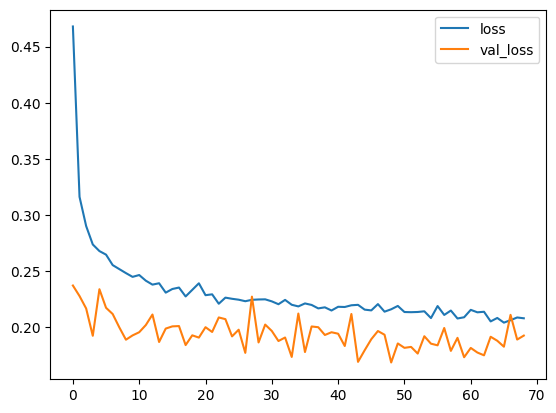

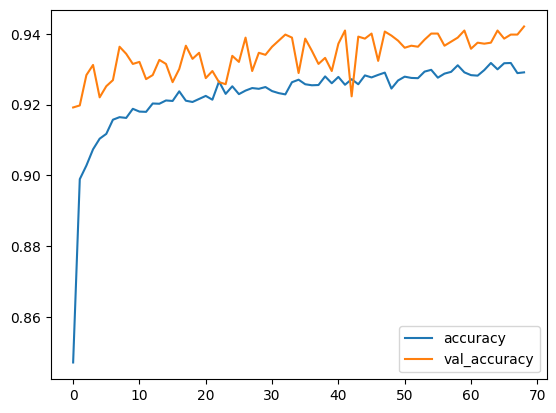

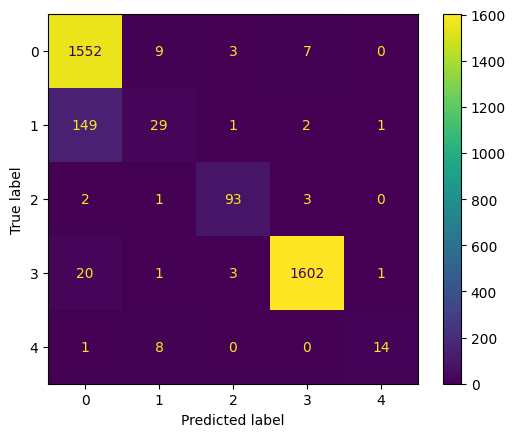

In [16]:
def lstm():
    model = Sequential()
    model.add(LSTM(128, activation='swish', return_sequences=True, input_shape=(1,X_train.shape[2])))
    model.add(Dropout(0.25))
    model.add(LSTM(128, activation='swish'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='swish'))
    model.add(Dense(y_val.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

model_lstm = lstm()
model_lstm.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model_lstm.fit(X_train, y_train, epochs = 100,
                        callbacks = early_stopping,
                        batch_size = 64, 
                        validation_data = (X_val, y_val))

loss, accuracy = model_lstm.evaluate(X_val, y_val, verbose=0)
accuracy

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_val_pred=model_lstm.predict(X_val)
y_pred_classes = np.argmax(y_val_pred,axis = 1) 
y_true = np.argmax(y_val,axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=range(5))
disp.plot()

In [17]:
def MVD_parse_filenames_in_directory(directory):
    filenames = os.listdir(directory)
    data = []
    for filename in filenames:
        vehicle = filename[-5]

        data.append([filename, vehicle])
    df = pd.DataFrame(data, columns=['filename', 'vehicle'])
    return df

audio_dir_MVD = '/kaggle/input/mvd-dataset/MVD'
df_origin_MVD = MVD_parse_filenames_in_directory(audio_dir_MVD)

In [18]:
df_origin_MVD['vehicle'].value_counts()

vehicle
M    1122
T    1077
N    1025
C    1005
Name: count, dtype: int64

In [19]:
'''def features_extractor_MVD(filename):
    y, sr = librosa.load(audio_dir_MVD + '/' + filename)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr).T, axis=0)
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
    output = np.hstack((mfccs,chroma_stft,rms))
    return output

filenames = os.listdir(audio_dir_MVD)
data_MVD=[]
for filename in tqdm(filenames):
    features = features_extractor_MVD(filename)
    data_MVD.append([filename,features])

data_dicts_MVD = []

for item in data_MVD:
    filename = item[0]
    features = item[1]
    
    data_dict_MVD = {'filename': filename}
    
    for i, feature in enumerate(features, start=1):
        data_dict_MVD[f'feature_{i}'] = feature
        
    data_dicts_MVD.append(data_dict_MVD)

df_MVD_mfccs_chromastft_rms = pd.DataFrame(data_dicts_MVD)

df_MVD_mfccs_chromastft_rms.to_csv('df_MVD_mfccs_chromastft_rms', index=False)'''

"def features_extractor_MVD(filename):\n    y, sr = librosa.load(audio_dir_MVD + '/' + filename)\n    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr).T, axis=0)\n    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)\n    rms = np.mean(librosa.feature.rms(y=y).T, axis=0)\n    output = np.hstack((mfccs,chroma_stft,rms))\n    return output\n\nfilenames = os.listdir(audio_dir_MVD)\ndata_MVD=[]\nfor filename in tqdm(filenames):\n    features = features_extractor_MVD(filename)\n    data_MVD.append([filename,features])\n\ndata_dicts_MVD = []\n\nfor item in data_MVD:\n    filename = item[0]\n    features = item[1]\n    \n    data_dict_MVD = {'filename': filename}\n    \n    for i, feature in enumerate(features, start=1):\n        data_dict_MVD[f'feature_{i}'] = feature\n        \n    data_dicts_MVD.append(data_dict_MVD)\n\ndf_MVD_mfccs_chromastft_rms = pd.DataFrame(data_dicts_MVD)\n\ndf_MVD_mfccs_chromastft_rms.to_csv('df_MVD_mfccs_chromastft_rms', index=False)"

In [20]:
df_MVD_mfccs_chromastft_rms = pd.read_csv('/kaggle/input/df-mvd-mfccs-chromastft-rms/df_MVD_mfccs_chromastft_rms')

In [21]:
X_MVD=df_MVD_mfccs_chromastft_rms.copy()
X_MVD.drop('filename', axis=1, inplace=True)
y_MVD=df_origin_MVD['vehicle']
y_MVD = pd.DataFrame(y_MVD)

from sklearn.preprocessing import OneHotEncoder
categories = [['C', 'T', 'M', 'N']]
encoder = OneHotEncoder(categories=categories, sparse=False)
y_MVD_encoded = encoder.fit_transform(y_MVD)

X_MVD_train, X_MVD_val, y_MVD_train, y_MVD_val = train_test_split(X_MVD, y_MVD_encoded, test_size=0.2, random_state=0)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [22]:
X_MVD_train = X_MVD_train.values.reshape(X_MVD_train.shape[0], 1, X_MVD_train.shape[1])
X_MVD_val = X_MVD_val.values.reshape(X_MVD_val.shape[0], 1, X_MVD_val.shape[1])

In [23]:
'''def lstm(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_activation = hp.Choice('activation', values=['relu', 'swish'])
    model.add(LSTM(units=hp_units, activation=hp_activation, input_shape=(1, X_MVD_train.shape[2]), return_sequences=True))
    hp_dropout = hp.Choice('Dropout', values=[0.1, 0.25])
    model.add(Dropout(hp_dropout))
    
    hp_lstm_layers = hp.Int('lstm_layers', min_value=1, max_value=2)
    for i in range(1, hp_lstm_layers):
        model.add(LSTM(hp_units, activation=hp_activation, return_sequences=True))
        model.add(Dropout(hp_dropout))
        
    model.add(LSTM(hp_units, activation=hp_activation, return_sequences=False))
    model.add(Dropout(hp_dropout))
    
    model.add(Dense(hp_units // 2, activation='relu'))
    model.add(Dense(y_MVD_val.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

tuner = keras_tuner.RandomSearch(
    lstm,
    objective='val_loss',
    max_trials=10
)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
tuner.search(X_MVD_train, y_MVD_train, epochs=100, callbacks=[early_stopping], batch_size=64, validation_data=(X_MVD_val, y_MVD_val))
best_model_MVD = tuner.get_best_models()[0]

MVD_val_loss, MVD_val_accuracy = best_model_MVD.evaluate(X_MVD_val, y_MVD_val)
print(f"MVD Validation Accuracy: {MVD_val_accuracy:.4f}")
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hyperparameters.values}")'''

'def lstm(hp):\n    model = Sequential()\n    hp_units = hp.Int(\'units\', min_value=32, max_value=512, step=32)\n    hp_activation = hp.Choice(\'activation\', values=[\'relu\', \'swish\'])\n    model.add(LSTM(units=hp_units, activation=hp_activation, input_shape=(1, X_MVD_train.shape[2]), return_sequences=True))\n    hp_dropout = hp.Choice(\'Dropout\', values=[0.1, 0.25])\n    model.add(Dropout(hp_dropout))\n    \n    hp_lstm_layers = hp.Int(\'lstm_layers\', min_value=1, max_value=2)\n    for i in range(1, hp_lstm_layers):\n        model.add(LSTM(hp_units, activation=hp_activation, return_sequences=True))\n        model.add(Dropout(hp_dropout))\n        \n    model.add(LSTM(hp_units, activation=hp_activation, return_sequences=False))\n    model.add(Dropout(hp_dropout))\n    \n    model.add(Dense(hp_units // 2, activation=\'relu\'))\n    model.add(Dense(y_MVD_val.shape[1], activation=\'softmax\'))\n\n    model.compile(loss=\'categorical_crossentropy\', optimizer=\'adam\', metrics=[\'ac

In [24]:
def lstm_MVD():
    model = Sequential()
    model.add(LSTM(units=480, activation='swish', input_shape=(1, X_MVD_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.1))
    
    for i in range(1, 2):
        model.add(LSTM(480, activation='swish', return_sequences=True))
        model.add(Dropout(0.1))
        
    model.add(LSTM(480, activation='swish', return_sequences=False))
    model.add(Dropout(0.1))
    
    model.add(Dense(480 // 2, activation='relu'))
    model.add(Dense(y_MVD_val.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_lstm_MVD = lstm_MVD()
model_lstm_MVD.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_MVD = model_lstm_MVD.fit(X_MVD_train, y_MVD_train, epochs = 100,
                        callbacks = early_stopping,
                        batch_size = 64, 
                        validation_data = (X_MVD_val, y_MVD_val))
MVD_loss, MVD_accuracy = model_lstm_MVD.evaluate(X_MVD_val, y_MVD_val, verbose=0)
MVD_accuracy

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 480)         │       986,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 480)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 480)         │     1,845,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 480)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 480)            │     1,845,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 240)            │       115,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           964 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,793,524 (18.29 MB)

 Trainable params: 4,793,524 (18.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - accuracy: 0.6439 - loss: 0.8618 - val_accuracy: 0.8310 - val_loss: 0.4316
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8350 - loss: 0.4094 - val_accuracy: 0.8452 - val_loss: 0.3980
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8443 - loss: 0.3783 - val_accuracy: 0.8463 - val_loss: 0.3833
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8691 - loss: 0.3440 - val_accuracy: 0.8605 - val_loss: 0.3696
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8570 - loss: 0.3494 - val_accuracy: 0.8712 - val_loss: 0.3467
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8663 - loss: 0.3218 - val_accuracy: 0.8546 - val_loss: 0.4072
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8710 - loss: 0.3275 - val_accuracy: 0.8712 - val_loss: 0.3447
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8787 - loss: 0.3000 - val_accuracy: 0.8818 

0.8912529349327087

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


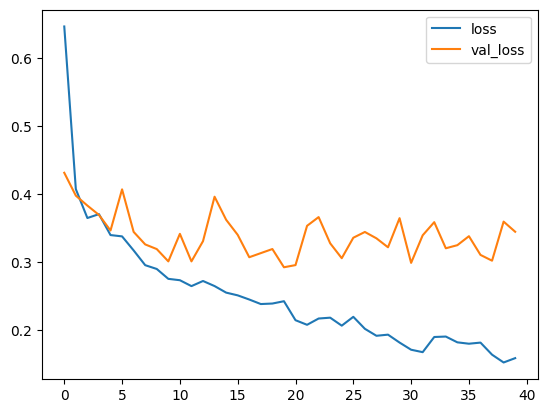

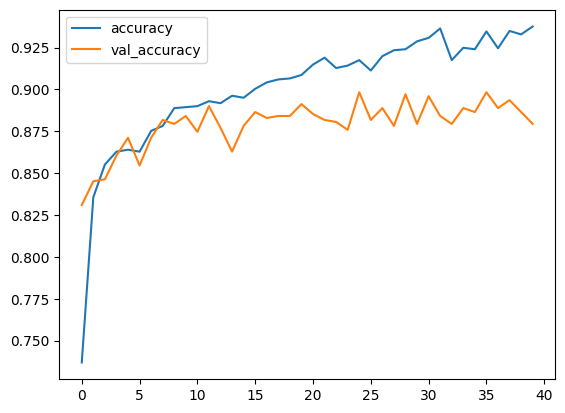

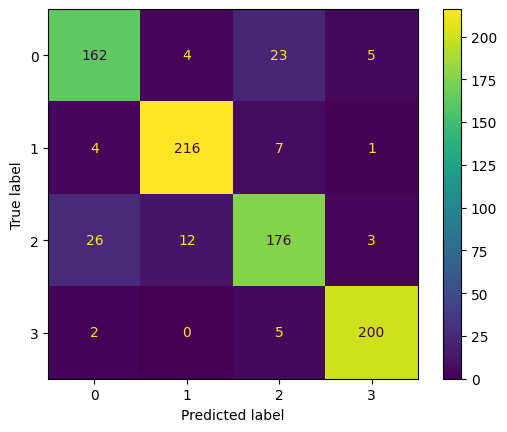

In [25]:
history_frame_MVD = pd.DataFrame(history_MVD.history)
history_frame_MVD.loc[:, ['loss', 'val_loss']].plot()
history_frame_MVD.loc[:, ['accuracy', 'val_accuracy']].plot()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_MVD_val_pred=model_lstm_MVD.predict(X_MVD_val)
y_MVD_pred_classes = np.argmax(y_MVD_val_pred,axis = 1) 
y_MVD_true = np.argmax(y_MVD_val,axis = 1) 
confusion_mtx_MVD = confusion_matrix(y_MVD_true, y_MVD_pred_classes) 
disp_MVD = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx_MVD, display_labels=range(4))
disp_MVD.plot()

In [26]:
'''from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(build_fn=lstm, verbose=1)

param_grid = {
    'batch_size': [64,128, 256],
    'optimizer': ['rmsprop', 'adam'],
    'activation': ['relu','swish'],
    'dropout_rate': [0.0, 0.1, 0.2, 0.25]
}


grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X, y_encoded)


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))'''

'from sklearn.model_selection import GridSearchCV\nfrom scikeras.wrappers import KerasClassifier\n\nmodel = KerasClassifier(build_fn=lstm, verbose=1)\n\nparam_grid = {\n    \'batch_size\': [64,128, 256],\n    \'optimizer\': [\'rmsprop\', \'adam\'],\n    \'activation\': [\'relu\',\'swish\'],\n    \'dropout_rate\': [0.0, 0.1, 0.2, 0.25]\n}\n\n\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)\ngrid_result = grid.fit(X, y_encoded)\n\n\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))'

In [27]:
def starts_with_B(filename):
    file_components = filename.split('_')
    if len(file_components) >= 7:
        return file_components[6][0] == 'B'
    else:
        return False

# Apply the function and filter out rows
df_B = df_origin[~df_origin['filename'].apply(starts_with_B)]
df_B_mfccs_chromastft_rms = df_mfccs_chromastft_rms[~df_mfccs_chromastft_rms['filename'].apply(starts_with_B)]

In [28]:
X_B=df_B_mfccs_chromastft_rms.copy()
X_B.drop('filename', axis=1, inplace=True)
y_B=df_B['Vehicle']
y_B = pd.DataFrame(y_B)

from sklearn.preprocessing import OneHotEncoder
y_B_encoded = encoder.fit_transform(y_B)

X_B_train, X_B_val, y_B_train, y_B_val = train_test_split(X_B, y_B_encoded, test_size=0.2, random_state=0, stratify=y_B_encoded)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [29]:
X_B_train = X_B_train.values.reshape(X_B_train.shape[0], 1, X_B_train.shape[1])
X_B_val = X_B_val.values.reshape(X_B_val.shape[0], 1, X_B_val.shape[1])

In [30]:
'''file_path = "./untitled_project/tuner0.json"  # Adjust the path as needed

# Check if the file exists before attempting to delete it
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"File '{file_path}' has been deleted.")
else:
    print(f"File '{file_path}' does not exist.")'''

'file_path = "./untitled_project/tuner0.json"  # Adjust the path as needed\n\n# Check if the file exists before attempting to delete it\nif os.path.exists(file_path):\n    os.remove(file_path)\n    print(f"File \'{file_path}\' has been deleted.")\nelse:\n    print(f"File \'{file_path}\' does not exist.")'

In [31]:
'''def lstm(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_activation = hp.Choice('activation', values=['relu', 'swish'])
    model.add(LSTM(units=hp_units, activation=hp_activation, input_shape=(X_B_train.shape[1], X_B_train.shape[2]), return_sequences=True))
    hp_dropout = hp.Choice('Dropout', values=[0.1, 0.25])
    model.add(Dropout(hp_dropout))
    
    hp_lstm_layers = hp.Int('lstm_layers', min_value=1, max_value=3)
    for i in range(1, hp_lstm_layers):
        model.add(LSTM(hp_units, activation=hp_activation, return_sequences=True))
        model.add(Dropout(hp_dropout))
        
    model.add(LSTM(hp_units, activation=hp_activation, return_sequences=False))
    model.add(Dropout(hp_dropout))
    
    model.add(Dense(hp_units // 2, activation='relu'))
    model.add(Dense(y_B_val.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

tuner = keras_tuner.RandomSearch(
    lstm,
    objective='val_loss',
    max_trials=10
)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
tuner.search(X_B_train, y_B_train, epochs=100, callbacks=[early_stopping], batch_size=64, validation_data=(X_B_val, y_B_val))
best_model_B = tuner.get_best_models()[0]

B_val_loss, B_val_accuracy = best_model_B.evaluate(X_B_val, y_B_val)
print(f"B Validation Accuracy: {B_val_accuracy:.4f}")
B_best_hyperparameters = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {B_best_hyperparameters.values}")'''

'def lstm(hp):\n    model = Sequential()\n    hp_units = hp.Int(\'units\', min_value=32, max_value=512, step=32)\n    hp_activation = hp.Choice(\'activation\', values=[\'relu\', \'swish\'])\n    model.add(LSTM(units=hp_units, activation=hp_activation, input_shape=(X_B_train.shape[1], X_B_train.shape[2]), return_sequences=True))\n    hp_dropout = hp.Choice(\'Dropout\', values=[0.1, 0.25])\n    model.add(Dropout(hp_dropout))\n    \n    hp_lstm_layers = hp.Int(\'lstm_layers\', min_value=1, max_value=3)\n    for i in range(1, hp_lstm_layers):\n        model.add(LSTM(hp_units, activation=hp_activation, return_sequences=True))\n        model.add(Dropout(hp_dropout))\n        \n    model.add(LSTM(hp_units, activation=hp_activation, return_sequences=False))\n    model.add(Dropout(hp_dropout))\n    \n    model.add(Dense(hp_units // 2, activation=\'relu\'))\n    model.add(Dense(y_B_val.shape[1], activation=\'softmax\'))\n\n    model.compile(loss=\'categorical_crossentropy\', optimizer=\'adam\', 

In [32]:
def lstm_B():
    model = Sequential()
    model.add(LSTM(units=64, activation='swish', input_shape=(1, X_B_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.1))
    
    for i in range(1, 2):
        model.add(LSTM(64, activation='swish', return_sequences=True))
        model.add(Dropout(0.1))
        
    model.add(LSTM(64, activation='swish', return_sequences=False))
    model.add(Dropout(0.1))
    
    model.add(Dense(64 // 2, activation='relu'))
    model.add(Dense(y_MVD_val.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_lstm_B = lstm_B()

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_B = model_lstm_B.fit(X_B_train, y_B_train, epochs = 100,
                        callbacks = early_stopping,
                        batch_size = 64, 
                        validation_data = (X_B_val, y_B_val))
B_loss, B_accuracy = model_lstm_B.evaluate(X_B_val, y_B_val, verbose=0)
B_accuracy

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



218/218 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.7119 - loss: 0.7516 - val_accuracy: 0.9118 - val_loss: 0.2687
Epoch 2/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8980 - loss: 0.3119 - val_accuracy: 0.9164 - val_loss: 0.2446
Epoch 3/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9088 - loss: 0.2680 - val_accuracy: 0.9207 - val_loss: 0.2370
Epoch 4/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9131 - loss: 0.2526 - val_accuracy: 0.9218 - val_loss: 0.2309
Epoch 5/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9168 - loss: 0.2460 - val_accuracy: 0.9256 - val_loss: 0.2213
Epoch 6/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9175 - loss: 0.2456 - val_accuracy: 0.9227 - val_loss: 0.2359
Epoch 7/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9189 - loss: 0.2359 - val_accuracy: 0.9201 - val_loss: 0.2326
Epoch 8/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9223 - loss: 0.2262 - val_accuracy: 0.92

0.9301724433898926

In [33]:
MVD_test_IDMT_loss, MVD_test_IDMT_accuracy = model_lstm_MVD.evaluate(X_B_val, y_B_val)
print(MVD_test_IDMT_accuracy)
IDMT_test_MVD_loss, IDMT_test_MVD_accuracy = model_lstm_B.evaluate(X_MVD_val, y_MVD_val)
print(IDMT_test_MVD_accuracy)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6781 - loss: 1.0543
0.6764367818832397
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4900 - loss: 3.0093
0.4716311991214752


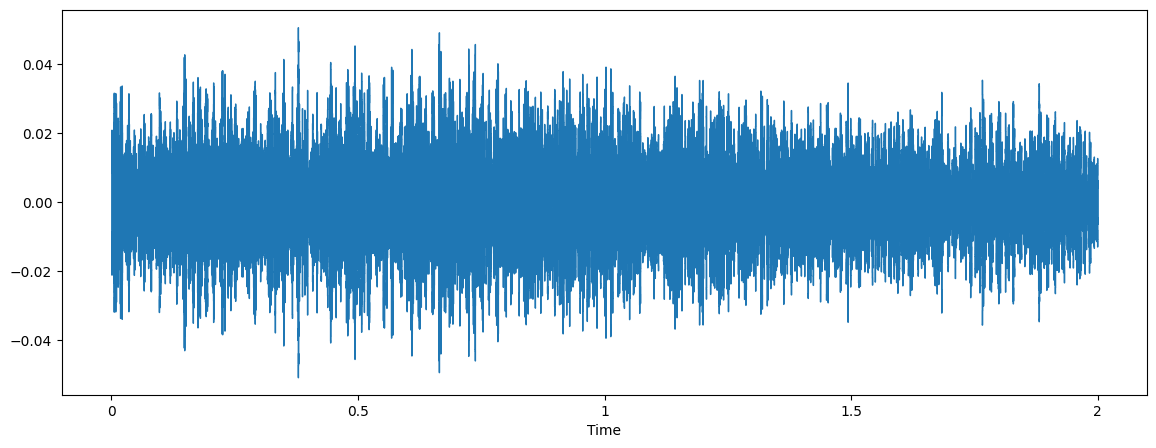

In [34]:
# IDMT Car
filename = "/kaggle/input/idmt-traffic-dataset/IDMT_Traffic/audio/2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1419885_M_D_CL_ME_CH12.wav"
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(filename)

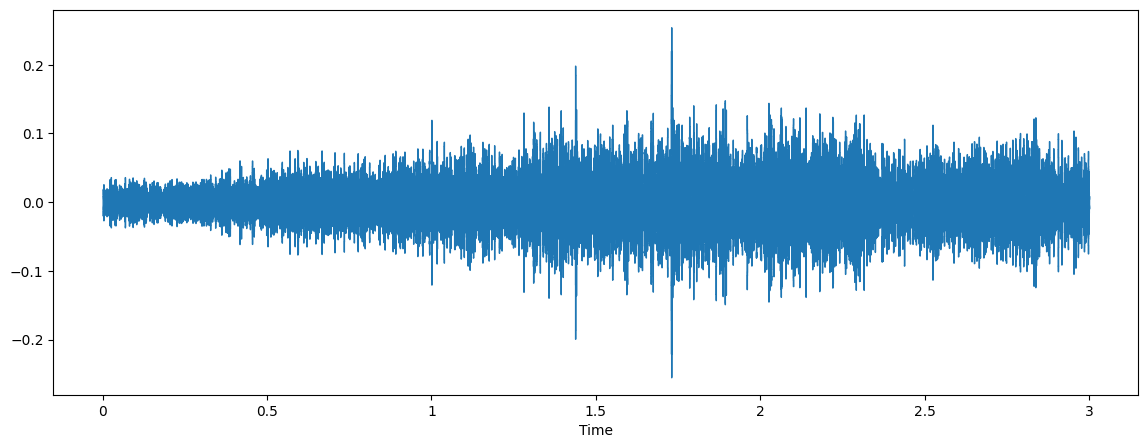

In [35]:
# MVD Car
filename = "/kaggle/input/mvd-dataset/MVD/Recording_1006_O_C.wav"
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(filename)

In [36]:
df_joint_mfccs_chromastft_rms = pd.concat([df_B_mfccs_chromastft_rms,df_MVD_mfccs_chromastft_rms])
y_joint = pd.concat([df_B['Vehicle'], df_origin_MVD['vehicle']])

In [37]:
X_joint=df_joint_mfccs_chromastft_rms.copy()
X_joint.drop('filename', axis=1, inplace=True)
y_joint = pd.DataFrame(y_joint)

from sklearn.preprocessing import OneHotEncoder
y_joint_encoded = encoder.fit_transform(y_joint)

X_joint_train, X_joint_val, y_joint_train, y_joint_val = train_test_split(X_joint, y_joint_encoded, test_size=0.2, random_state=0, stratify=y_joint_encoded)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [38]:
X_joint_train = X_joint_train.values.reshape(X_joint_train.shape[0], 1, X_joint_train.shape[1])
X_joint_val = X_joint_val.values.reshape(X_joint_val.shape[0], 1, X_joint_val.shape[1])

In [39]:
'''def lstm(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_activation = hp.Choice('activation', values=['relu', 'swish'])
    model.add(LSTM(units=hp_units, activation=hp_activation, input_shape=(X_joint_train.shape[1], X_B_train.shape[2]), return_sequences=True))
    hp_dropout = hp.Choice('Dropout', values=[0.1, 0.25])
    model.add(Dropout(hp_dropout))
    
    hp_lstm_layers = hp.Int('lstm_layers', min_value=1, max_value=3)
    for i in range(1, hp_lstm_layers):
        model.add(LSTM(hp_units, activation=hp_activation, return_sequences=True))
        model.add(Dropout(hp_dropout))
        
    model.add(LSTM(hp_units, activation=hp_activation, return_sequences=False))
    model.add(Dropout(hp_dropout))
    
    model.add(Dense(hp_units // 2, activation='relu'))
    model.add(Dense(y_joint_val.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

tuner = keras_tuner.RandomSearch(
    lstm,
    objective='val_loss',
    max_trials=10
)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
tuner.search(X_joint_train, y_joint_train, epochs=100, callbacks=[early_stopping], batch_size=64, validation_data=(X_joint_val, y_joint_val))
best_model_joint = tuner.get_best_models()[0]

joint_val_loss, joint_val_accuracy = best_model_joint.evaluate(X_joint_val, y_joint_val)
print(f"B Validation Accuracy: {joint_val_accuracy:.4f}")
joint_best_hyperparameters = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {joint_best_hyperparameters.values}")'''

'def lstm(hp):\n    model = Sequential()\n    hp_units = hp.Int(\'units\', min_value=32, max_value=512, step=32)\n    hp_activation = hp.Choice(\'activation\', values=[\'relu\', \'swish\'])\n    model.add(LSTM(units=hp_units, activation=hp_activation, input_shape=(X_joint_train.shape[1], X_B_train.shape[2]), return_sequences=True))\n    hp_dropout = hp.Choice(\'Dropout\', values=[0.1, 0.25])\n    model.add(Dropout(hp_dropout))\n    \n    hp_lstm_layers = hp.Int(\'lstm_layers\', min_value=1, max_value=3)\n    for i in range(1, hp_lstm_layers):\n        model.add(LSTM(hp_units, activation=hp_activation, return_sequences=True))\n        model.add(Dropout(hp_dropout))\n        \n    model.add(LSTM(hp_units, activation=hp_activation, return_sequences=False))\n    model.add(Dropout(hp_dropout))\n    \n    model.add(Dense(hp_units // 2, activation=\'relu\'))\n    model.add(Dense(y_joint_val.shape[1], activation=\'softmax\'))\n\n    model.compile(loss=\'categorical_crossentropy\', optimizer=\'

In [40]:
def lstm_joint():
    model = Sequential()
    model.add(LSTM(units=416, activation='relu', input_shape=(1, X_joint_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.25))
    
    for i in range(1, 2):
        model.add(LSTM(416, activation='relu', return_sequences=True))
        model.add(Dropout(0.25))
        
    model.add(LSTM(416, activation='relu', return_sequences=False))
    model.add(Dropout(0.25))
    
    model.add(Dense(416 // 2, activation='relu'))
    model.add(Dense(y_joint_val.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_lstm_joint = lstm_joint()

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_joint = model_lstm_joint.fit(X_joint_train, y_joint_train, epochs = 100,
                        callbacks = early_stopping,
                        batch_size = 64, 
                        validation_data = (X_joint_val, y_joint_val))
joint_loss, joint_accuracy = model_lstm_joint.evaluate(X_joint_val, y_joint_val, verbose=0)
joint_accuracy

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.7836 - loss: 0.5657 - val_accuracy: 0.8812 - val_loss: 0.3334
Epoch 2/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8816 - loss: 0.3366 - val_accuracy: 0.8971 - val_loss: 0.2921
Epoch 3/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8899 - loss: 0.3119 - val_accuracy: 0.9036 - val_loss: 0.2728
Epoch 4/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8921 - loss: 0.2994 - val_accuracy: 0.9022 - val_loss: 0.2886
Epoch 5/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9002 - loss: 0.2864 - val_accuracy: 0.9041 - val_loss: 0.2538
Epoch 6/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8954 - loss: 0.2866 - val_accuracy: 0.9066 - val_loss: 0.2557
Epoch 7/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9042 - loss: 0.2670 - val_accuracy: 0.9064 - val_loss: 0.2638
Epoch 8/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8979 - loss: 0.2794 - val_ac

0.9207119941711426

136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


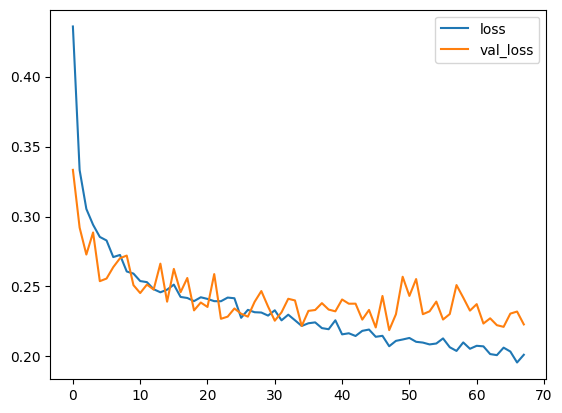

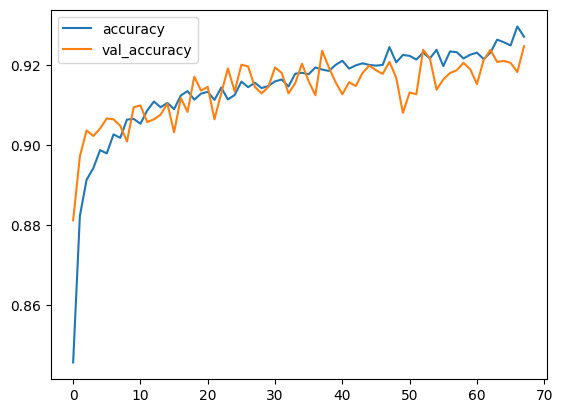

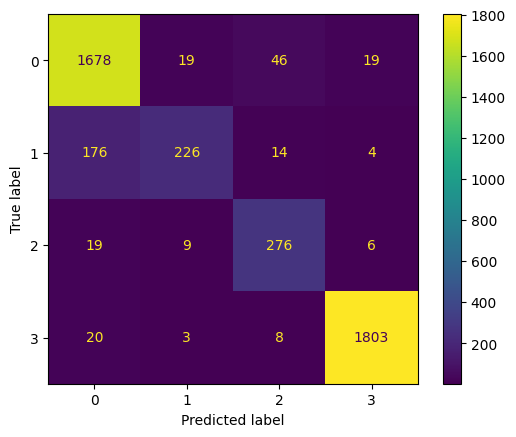

In [41]:
history_frame_joint = pd.DataFrame(history_joint.history)
history_frame_joint.loc[:, ['loss', 'val_loss']].plot()
history_frame_joint.loc[:, ['accuracy', 'val_accuracy']].plot()

y_joint_val_pred=model_lstm_joint.predict(X_joint_val)
y_joint_pred_classes = np.argmax(y_joint_val_pred,axis = 1) 
y_joint_true = np.argmax(y_joint_val,axis = 1) 
confusion_mtx_joint = confusion_matrix(y_joint_true, y_joint_pred_classes) 
disp_joint = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx_joint, display_labels=range(4))
disp_joint.plot()

In [42]:
joint_test_IDMT_loss, joint_test_IDMT_accuracy = model_lstm_joint.evaluate(X_B_val, y_B_val)
print(joint_test_IDMT_accuracy)
joint_test_MVD_loss, joint_test_MVD_accuracy = model_lstm_joint.evaluate(X_MVD_val, y_MVD_val)
print(joint_test_MVD_accuracy)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9347 - loss: 0.1769
0.9379310607910156
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9198 - loss: 0.2256
0.9125295281410217


In [43]:
IDMT_test_joint_loss, IDMT_test_joint_accuracy = model_lstm_B.evaluate(X_joint_val, y_joint_val)
print(IDMT_test_joint_accuracy)
MVD_test_joint_loss, MVD_test_joint_accuracy = model_lstm_MVD.evaluate(X_joint_val, y_joint_val)
print(IDMT_test_joint_accuracy)

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8516 - loss: 0.7511
0.8513638377189636
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7125 - loss: 0.8662
0.8513638377189636
